<a href="https://colab.research.google.com/github/Roua91/Reaserch_Project/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install torch torchvision


In [16]:
from google.colab import files
uploaded = files.upload()


for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
  name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [17]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
breast-ultrasound-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
from zipfile import ZipFile
file_name = "/content/breast-ultrasound-images-dataset.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
print('Done')

Done


In [19]:
import os

# Path to the dataset directory
dataset_dir = '/content/Dataset_BUSI_with_GT'

import shutil


# Path to the 'normal' directory
normal_dir_path = '/content/Dataset_BUSI_with_GT/normal'

# Check if the directory exists
if os.path.exists(normal_dir_path) and os.path.isdir(normal_dir_path):
    # Remove the 'normal' directory and all its contents
    shutil.rmtree(normal_dir_path)
    print(f"'{normal_dir_path}' has been removed.")
else:
    print(f"The directory '{normal_dir_path}' does not exist or is not a directory.")

all_files = os.listdir(dataset_dir)
print(all_files)


'/content/Dataset_BUSI_with_GT/normal' has been removed.
['benign', 'malignant']


In [20]:
def check_images_and_masks(directory):
    images = [f for f in os.listdir(directory) if f.endswith('.png') and not f.endswith('_mask.png')]
    masks = [f for f in os.listdir(directory) if f.endswith('_mask.png')]
    print(f"In {directory}: {len(images)} images, {len(masks)} masks")
    return images, masks

# Check images and masks in both directories
benign_dir = '/content/Dataset_BUSI_with_GT/benign'
malignant_dir = '/content/Dataset_BUSI_with_GT/malignant'
benign_images, benign_masks = check_images_and_masks(benign_dir)
malignant_images, malignant_masks = check_images_and_masks(malignant_dir)


In /content/Dataset_BUSI_with_GT/benign: 454 images, 437 masks
In /content/Dataset_BUSI_with_GT/malignant: 211 images, 210 masks


In [24]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# Directories and labels
dataset_dir = '/content/Dataset_BUSI_with_GT'
overlay_dir = '/content/OverlayOutput'
labels = ['benign', 'malignant']

# Ensure the overlay output directory exists
os.makedirs(overlay_dir, exist_ok=True)
for label in labels:
    os.makedirs(os.path.join(overlay_dir, label), exist_ok=True)

def overlay_and_save(image_path, mask_path, output_dir):
    try:
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        if os.path.isfile(output_path):
            print(f"Overlay image already exists: {output_path}, skipping.")
            return

        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            mask = mask.resize(image.size)
            rgba_mask = Image.new("RGBA", mask.size, (255, 192, 77, 0))
            rgba_mask.putalpha(mask)
            overlayed = Image.alpha_composite(image.convert("RGBA"), rgba_mask)
            overlayed.convert("RGB").save(output_path)
            print(f"Saved overlayed image to: {output_path}")
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

for label in labels:
    image_dir = os.path.join(dataset_dir, label)
    output_label_dir = os.path.join(overlay_dir, label)
    for image_filename in os.listdir(image_dir):
        if image_filename.endswith('.png'):
            image_path = os.path.join(image_dir, image_filename)
            mask_path = image_path.replace('.png', '_mask.png')
            overlay_and_save(image_path, mask_path, output_label_dir)

print("Overlayed images have been saved to the overlay directory.")

# Data transformation and augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the overlayed dataset
overlayed_dataset = datasets.ImageFolder(root=overlay_dir, transform=transform)

# Splitting dataset into train and test sets
train_idx, test_idx = train_test_split(range(len(overlayed_dataset)), test_size=0.2, random_state=42)

# Creating data loaders
train_loader = DataLoader(overlayed_dataset, batch_size=32, sampler=SubsetRandomSampler(train_idx))
test_loader = DataLoader(overlayed_dataset, batch_size=32, sampler=SubsetRandomSampler(test_idx))

dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_idx), 'test': len(test_idx)}
class_names = overlayed_dataset.classes

print(f"Dataset split complete: {len(train_loader)} training batches, {len(test_loader)} testing batches.")

Overlay image already exists: /content/OverlayOutput/benign/benign (115).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (114).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (240).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (282).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (382).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (328).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (294).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (117).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (372).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (21).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (80).png, skipping.
Overlay image already exists: /con

In [27]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Load pretrained model and modify for RGB input and binary classification
model = models.resnet50(pretrained=True)
# Change the first convolution layer to accept 3-channel (RGB) input
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")



Epoch 1/10, Loss: 0.6466258466243744
Epoch 2/10, Loss: 0.26832734245587797
Epoch 3/10, Loss: 0.18749634307973526
Epoch 4/10, Loss: 0.22703971889089136
Epoch 5/10, Loss: 0.16869840135469155
Epoch 6/10, Loss: 0.1753161762128858
Epoch 7/10, Loss: 0.12564437573446946
Epoch 8/10, Loss: 0.23142725601792336
Epoch 9/10, Loss: 0.271293307928478
Epoch 10/10, Loss: 0.2737819541464834


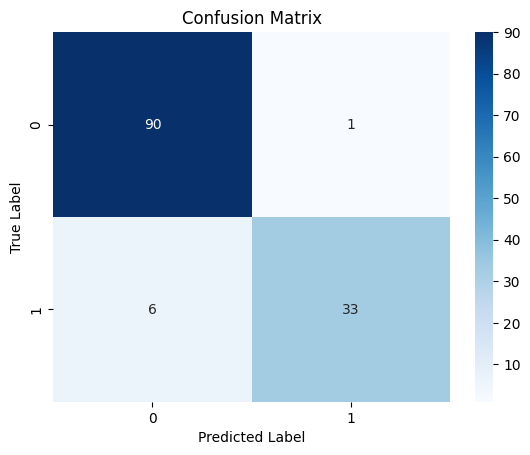

Accuracy: 0.9461538461538461
Precision: 0.9705882352941176
Recall: 0.8461538461538461
F1 Score: 0.9041095890410958
MCC Score: 0.8708635721768007
Kappa Score: 0.8669201520912547


In [29]:
# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MCC Score:", mcc)
print("Kappa Score:", kappa)